# Fundamental Analysis

### Loading Data

In [ ]:
import pandas as pd
from vnstock_ezchart import *
from vnstock import Vnstock
import warnings
warnings.filterwarnings("ignore")
# Instantiate 
stock = Vnstock().stock(symbol='REE', source='VCI')
company = Vnstock().stock(symbol="REE",source="TCBS").company

# Load
CashFlow = stock.finance.cash_flow(period='year')
BalanceSheet = stock.finance.balance_sheet(period='year', lang='en', dropna=True)
IncomeStatement = stock.finance.income_statement(period='year', lang='en', dropna=True)
Ratio = stock.finance.ratio(period='year', lang='en', dropna=True)
dividend_schedule = company.dividends()


### Calculation

In [ ]:
# Levered Free Cash Flow (accounts for debt repayments/receipts)
CashFlow['Levered Free Cash Flow'] = (
    CashFlow['Net cash inflows/outflows from operating activities'] 
    - CashFlow['Purchase of fixed assets']
    + CashFlow['Proceeds from disposal of fixed assets']
    - (CashFlow['Repayment of borrowings'] - CashFlow['Proceeds from borrowings'])
)

dividend_coverage_ratio = CashFlow['Levered Free Cash Flow'] / CashFlow['Dividends paid'].abs()

Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.5

2025-06-09 13:36:49 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


In [2]:
#Create a new column for Dividend Coverage calculation and add that column back to the original CashFlow dataframe
CashFlow['Dividend Coverage Ratio'] = CashFlow['Levered Free Cash Flow'] / CashFlow['Dividends paid'].abs()
# Select the 2 columns in CashFlow dataframe and store it in a new variable which create a new df for dividend coverage ratio
dividend_coverage_ratio = CashFlow[["yearReport", "Dividend Coverage Ratio"]]

,yearReport,Dividend Coverage Ratio
0,2024,11.789551
1,2023,11.488063
2,2022,12.004097
3,2021,137.285769
4,2020,9.822609
5,2019,11.071671
6,2018,6.772744
7,2017,13.247372
8,2016,16.893041
9,2015,6.004151


In [3]:
#Convert pandas series to dataframe 
dividend_coverage_ratio = pd.DataFrame(dividend_coverage_ratio)
FCF =CashFlow[['yearReport','Levered Free Cash Flow']]

,yearReport,Levered Free Cash Flow
0,2024,12103421743973
1,2023,10183013888571
2,2022,6896174874538
3,2021,11749663032428
4,2020,5935884666287
5,2019,6864057741231
6,2018,4074890119479
7,2017,7910029198951
8,2016,4955814931386
9,2015,3060842162057


# Langchain

In [4]:
# import pandas as pd
# from langchain_openai import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate
# import os
# from datetime import datetime

# # Check if API key is already set as an environment variable
# if "OPENAI_API_KEY" not in os.environ:
#     # If not set, you may want to load from .env file
#     # from dotenv import load_dotenv
#     # load_dotenv()
    
#     # Or set it directly (not recommended for production code)
#     os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# # Initialize the ChatGPT model
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# # Function to format DataFrame as a string for the prompt
# def format_dataframe(df):
#     return df.to_string()

# # Create a prompt template for comprehensive financial analysis
# prompt_template = ChatPromptTemplate.from_messages([
#     ("system", """You are a financial analyst expert. Analyze the following financial statements and ratios:
    
#     BALANCE SHEET:
#     {balance_sheet}
    
#     INCOME STATEMENT:
#     {income_statement}
    
#     CASH FLOW STATEMENT:
#     {cash_flow}
    
#     KEY FINANCIAL RATIOS:
#     {financial_ratios}
    
#     Provide the following comprehensive analysis:
#     1. Analysis of asset composition, liabilities and equity structure
#     2. Profitability analysis (margins, ROCE, ROE, ROIC)
#     3. Cash flow quality and trends
#     4. Evaluation of liquidity and solvency ratios
#     5. Assessment of working capital management
#     6. Year-over-year changes in key financial items
#     7. Integrated analysis showing relationships between the three statements
#     8. Dividend sustainability analysis based on the dividend coverage ratio
    
#     Be specific in your analysis and provide actionable insights.""")
# ])

# # Analyze function using all three financial statements
# def analyze_financial_statements(balance_sheet_df, income_statement_df, cash_flow_df):
#     # Calculate key financial ratios
#     financial_ratios = pd.DataFrame({
#         'Dividend Coverage Ratio': cash_flow_df['Levered Free Cash Flow'] / cash_flow_df['Dividends paid'].abs()
#         # Add other ratios as needed, maintaining the same index structure
#     })
    
#     # Format the DataFrames as strings
#     balance_sheet_string = format_dataframe(balance_sheet_df)
#     income_statement_string = format_dataframe(income_statement_df)
#     cash_flow_string = format_dataframe(cash_flow_df)
#     financial_ratios_string = format_dataframe(financial_ratios)
    
#     # Create a chain using the pipe operator
#     chain = prompt_template | llm
    
#     # Run the chain with all inputs
#     result = chain.invoke({
#         "balance_sheet": balance_sheet_string,
#         "income_statement": income_statement_string,
#         "cash_flow": cash_flow_string,
#         "financial_ratios": financial_ratios_string
#     })
    
#     return result.content

# # Now use your specific DataFrames
# # Assuming these DataFrames are already defined
# analysis = analyze_financial_statements(
#     BalanceSheet, 
#     IncomeStatement,  
#     CashFlow  
# )

# # Print analysis to notebook
# print(analysis)

# # Create markdown formatted content
# markdown_content = f"""# Comprehensive Financial Analysis

# ## Analysis
# {analysis}

# ---
# *Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}*
# """

# # Ensure output directory exists
# output_dir = "./output"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created output directory: {output_dir}")

# # Save the output as a markdown file in the output directory
# output_filename = f"{output_dir}/financial_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
# with open(output_filename, 'w', encoding='utf-8') as md_file:
#     md_file.write(markdown_content)

# print(f"\nAnalysis saved to {output_filename}")

# PandasAI

### Create an Agent with multiple DataFrames using PandasAI

In [ ]:
import os
from datetime import datetime
from pandasai import Agent
from pandasai.llm import OpenAI
from pandasai.responses.streamlit_response import StreamlitResponse

# Initialize the OpenAI LLM explicitly
llm = OpenAI(api_token=os.environ.get("OPENAI_API_KEY"),
            model_name="gpt-4o", temperature=0, seed=26)

# Create an Agent with multiple DataFrames and the OpenAI LLM
agent = Agent(
    [CashFlow, BalanceSheet, IncomeStatement, dividend_schedule],  # Pass all dataframes as a list
    config={"llm": llm, "verbose": True, "response_parser": StreamlitResponse}
)

### Save the response to a markdown file

In [ ]:
# Ensure output directory exists
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

def save_response_to_md(query, agent, filename="pandasai_response.md"):
    """Save PandasAI response to markdown file"""
    
    # Get response
    print(f"🔍 Processing: {query}")
    response = agent.chat(query)
    
    # Create markdown content
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    content = f"""## Query: {query}
**Timestamp:** {timestamp}

### Response:
{response}

---

"""
    
    # Save to file
    filepath = f"{output_dir}/{filename}"
    with open(filepath, 'a', encoding='utf-8') as f:
        f.write(content)
    
    print(f"✅ Saved to: {filepath}")
    return response

# Now you can ask questions that span across multiple dataframes
response = save_response_to_md("What is the return on invested capital in 2024", agent)
print(response)


🔍 Processing: What is the return on invested capital in 2024
2025-06-09 13:36:53 [INFO] Question: What is the return on invested capital in 2024
2025-06-09 13:36:53 [INFO] Running PandasAI with openai LLM...
2025-06-09 13:36:53 [INFO] Prompt ID: 770ef2e2-976f-402e-9e07-210e62a439ae
2025-06-09 13:36:53 [INFO] Executing Pipeline: GenerateChatPipeline
2025-06-09 13:36:53 [INFO] Executing Step 0: ValidatePipelineInput
2025-06-09 13:36:53 [INFO] Executing Step 1: CacheLookup
2025-06-09 13:36:53 [INFO] Using cached response
2025-06-09 13:36:53 [INFO] Executing Step 2: PromptGeneration
2025-06-09 13:36:53 [INFO] Executing Step 2: Skipping...
2025-06-09 13:36:53 [INFO] Executing Step 3: CodeGenerator
2025-06-09 13:36:53 [INFO] Executing Step 3: Skipping...
2025-06-09 13:36:53 [INFO] Executing Step 4: CachePopulation
2025-06-09 13:36:53 [INFO] Executing Step 4: Skipping...
2025-06-09 13:36:53 [INFO] Executing Step 5: CodeCleaning
2025-06-09 13:36:53 [INFO] 
Code running:
```
net_profit_2024 = d

### Create a loop to save multiple responses to a markdown file

In [ ]:

# Additional financial analysis queries
financial_queries = [
    "What's current asset in 2024"
    "What's the D/E in 2024"
]

# Process all queries and save to markdown
for query in financial_queries:
    save_response_to_md(query, agent)

print(f"\n✅ All analysis saved to: {output_dir}/pandasai_response.md")

### Clean the Ratio dataframe before feeding it to the agent

In [ ]:
import logging
# Fix Windows Unicode encoding issues
os.environ['PYTHONIOENCODING'] = 'utf-8'

# Optionally disable verbose logging to avoid Unicode errors
logging.getLogger('pandasai').setLevel(logging.ERROR)
# Step 2: Clean the multi-index columns
def clean_columns(df):
    """Simple column cleaning for multi-index DataFrames"""
    new_columns = []
    for col in df.columns:
        if isinstance(col, tuple):
            # Join tuple with underscore and clean
            name = '_'.join(str(x) for x in col)
        else:
            name = str(col)
        
        # Basic cleaning
        name = name.replace('(', '').replace(')', '')
        name = name.replace('?', '').replace(' ', '_')
        name = name.replace(',', '').replace('/', '_')
        name = name.replace('%', 'Pct')
        
        new_columns.append(name)
    
    df.columns = new_columns
    return df

# Step 3: Setup your Ratio DataFrame
Ratio_clean = clean_columns(Ratio.copy())


✅ Ready! Now you can use:
agent.chat('your question here')


### Create another agent with the cleaned Ratio DataFrame

In [ ]:

config={"llm": llm, "verbose": True, "response_parser": StreamlitResponse}
# Step 4: Create the agent
ratio_agent = Agent([Ratio_clean],config=config)

print("✅ Ready! Now you can use:")
print("agent.chat('your question here')")

2025-06-09 14:26:57 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-09 14:26:57 [ERROR] Failed with error: Traceback (most recent call last):
  File "E:\Jupyter\.venv\lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
  File "E:\Jupyter\.venv\lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 174, in execute_code
    exec(code, environment)
  File "<string>", line 12, in <module>
  File "E:\Jupyter\.venv\lib\site-packages\pandasai\safe_libs\restricted_matplotlib.py", line 75, in __getattr__
    raise AttributeError(f"'{name}' is not allowed in RestrictedMatplotlib")
AttributeError: 'tight_layout' is not allowed in RestrictedMatplotlib

2025-06-09 14:27:01 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-09 14:27:01 [ERROR] Failed with error: Traceback (most recent call last):
  File "E:\Jupy

'E:/Jupyter/exports/charts/temp_chart.png'

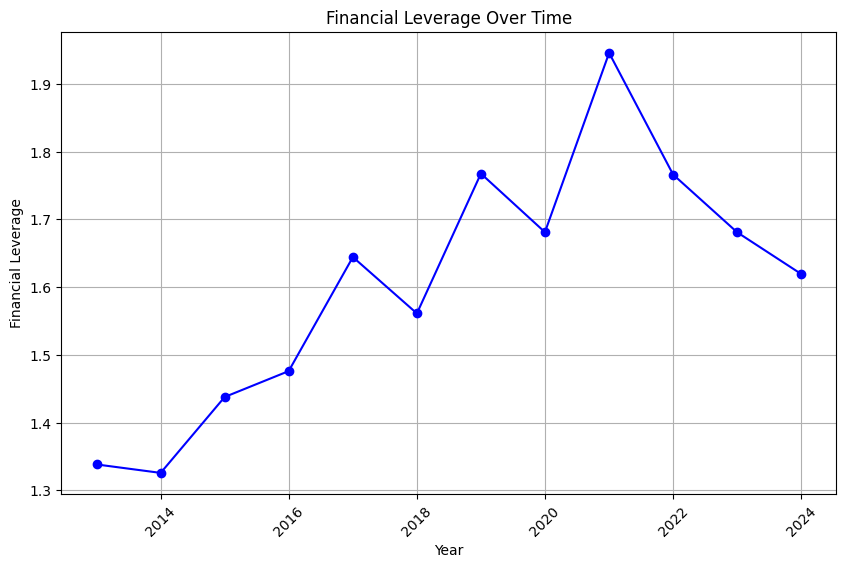

In [19]:
ratio_agent.chat("Plot financial leverage over time")